In [1]:
import sympy
sympy.init_printing()

In [2]:
# DH 파라미터를 이용해 Homogeneous Transformation Matrix 만드는 함수
def DH(a, alpha, d, theta):
    T_rot_x = sympy.Matrix([[1,0,0,0],
                            [0,sympy.cos(alpha),-sympy.sin(alpha),0],
                            [0,sympy.sin(alpha),sympy.cos(alpha),0],
                            [0,0,0,1]]);
    T_trans_x = sympy.Matrix([[1,0,0,a],
                              [0,1,0,0],
                              [0,0,1,0],
                              [0,0,0,1]]);
    T_trans_z = sympy.Matrix([[1,0,0,0],
                              [0,1,0,0],
                              [0,0,1,d],
                              [0,0,0,1]]);
    T_rot_z = sympy.Matrix([[sympy.cos(theta),-sympy.sin(theta),0,0],
                            [sympy.sin(theta),sympy.cos(theta),0,0],
                            [0,0,1,0],
                            [0,0,0,1]]);
    T = T_rot_x*T_trans_x*T_trans_z*T_rot_z;
    return T

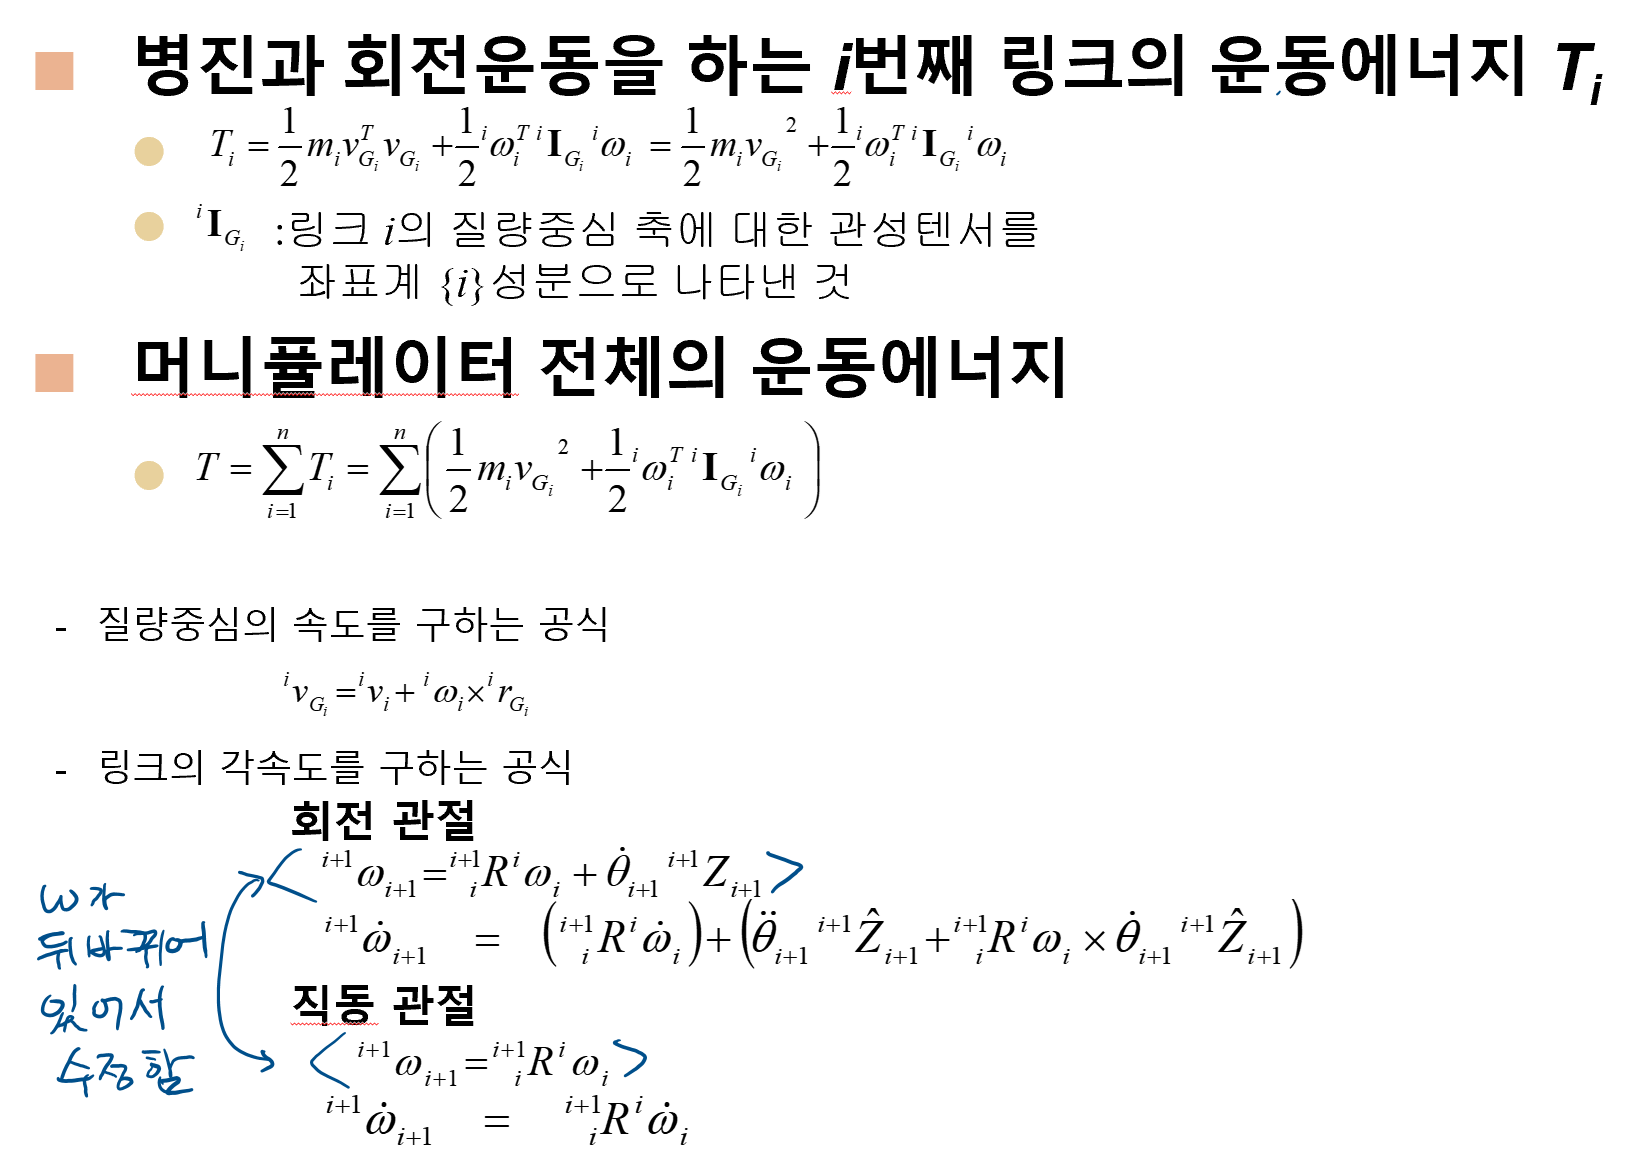

In [3]:
from IPython.display import Image
Image('T구하는공식.PNG', width=500)

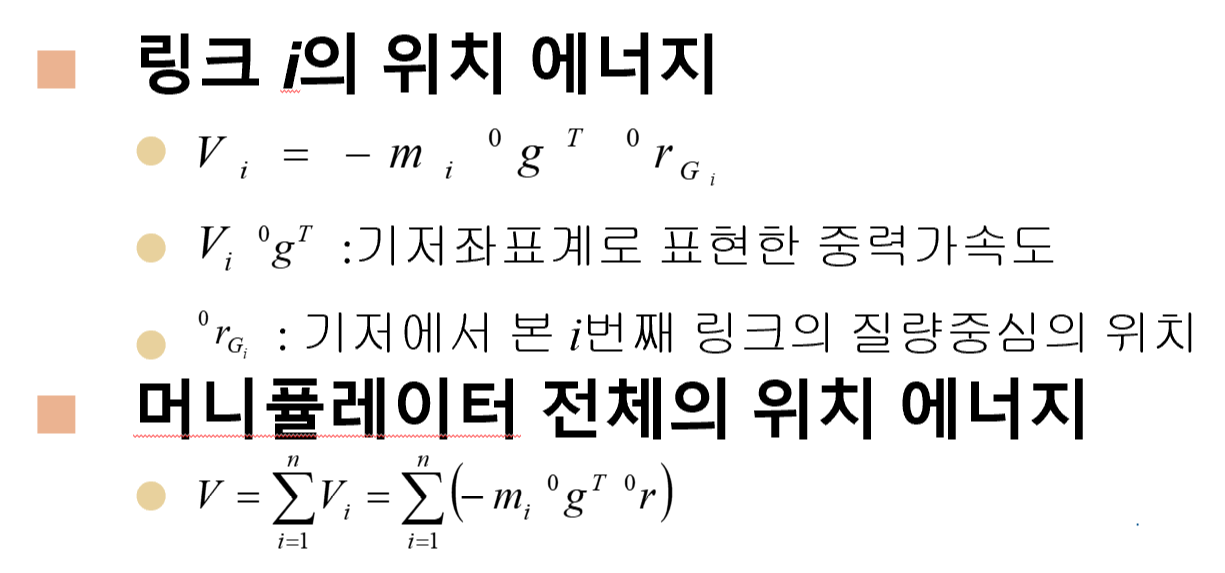

In [4]:
from IPython.display import Image
Image('V구하는공식.PNG', width=300)

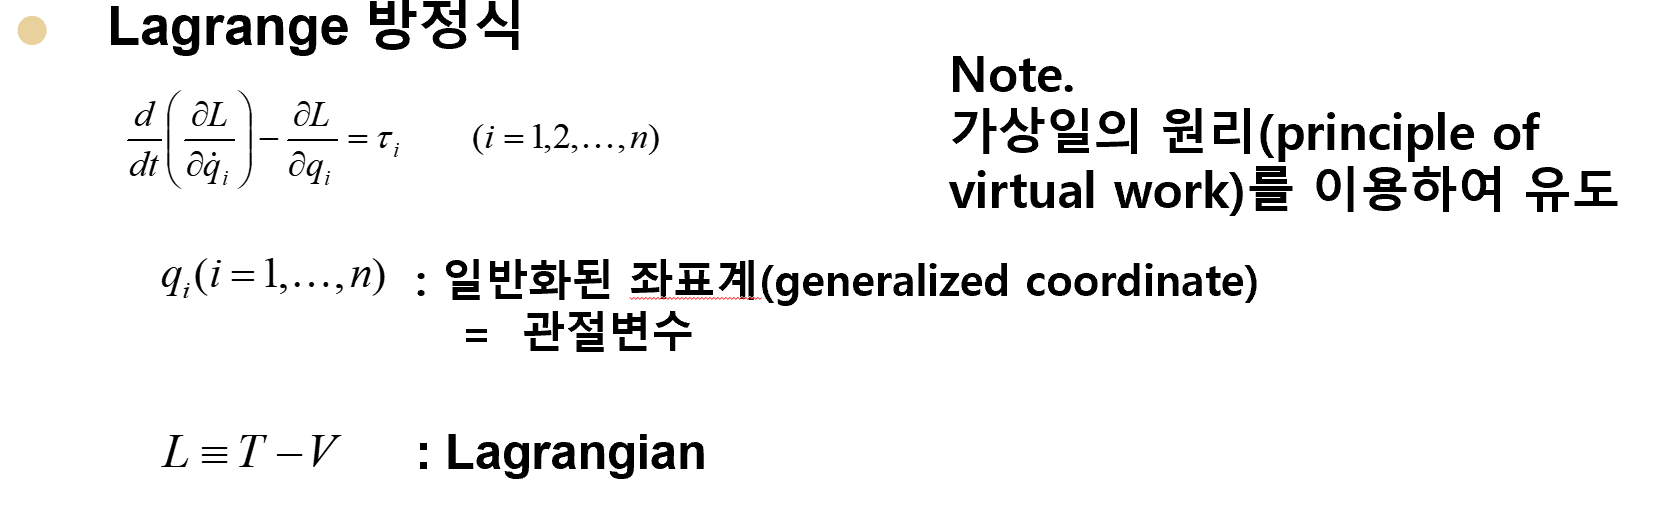

In [5]:
from IPython.display import Image
Image('L구하는공식.PNG', width=500)

In [6]:
###### 동역학 공식
# 동차변환에서 회전행렬만 뽑아내는 함수
def get_R_from_T(T):
    R = T[0:3,0:3];
    return R

# 동차변환에서 위치백터만 뽑아내는 함수
def get_P_from_T(T):
    P = T[0:3,3];
    return P

###### 운동에너지 T 구하는 부분
### 회전관절
# 속도전파식을 이용하여 각속도를 구하는 함수
def get_angular_vel_R(T_i_ip1,w_i_i,thd_ip1):
    R_i_ip1 = get_R_from_T(T_i_ip1);
    R_ip1_i = sympy.transpose(R_i_ip1);
    Z_ip1_ip1 = sympy.Matrix([[0],[0],[1]]);
    w_ip1_ip1 = R_ip1_i@w_i_i + thd_ip1*Z_ip1_ip1;
    return w_ip1_ip1    

# 속도전파식을 이용하여 선속도를 구하는 함수
def get_linear_vel_R(T_i_ip1,w_i,v_i):
    R_i_ip1 = get_R_from_T(T_i_ip1);
    R_ip1_i = sympy.transpose(R_i_ip1);
    r_i_ip1 = T_i_ip1[0:3,3:4];
    v_ip1_ip1 = R_ip1_i@(v_i + w_i.cross(r_i_ip1));
    return v_ip1_ip1

### 직동관절
# 속도전파식을 이용하여 각속도를 구하는 함수
def get_angular_vel_P(T_i_ip1,w_i_i):
    R_i_ip1 = get_R_from_T(T_i_ip1);
    R_ip1_i = sympy.transpose(R_i_ip1);
    w_ip1_ip1 = R_ip1_i@w_i_i;
    return w_ip1_ip1

# 속도전파식을 이용하여 선속도를 구하는 함수
def get_linear_vel_P(T_i_ip1,w_i_i,v_i_i,dd_ip1):
    R_i_ip1 = get_R_from_T(T_i_ip1);
    R_ip1_i = sympy.transpose(R_i_ip1);
    r_i_ip1 = T_i_ip1[0:3,3:4];
    Z_ip1_ip1 = sympy.Matrix([[0],[0],[1]]);
    v_ip1_ip1 = R_ip1_i@(v_i_i + w_i_i.cross(r_i_ip1)) + dd_ip1*Z_ip1_ip1;
    return v_ip1_ip1

# 질량중심의 속도 구하는 함수
def get_com_vel(v_i_i,w_i_i,r_i_Gi):
    v_i_Gi = v_i_i +  w_i_i.cross(r_i_Gi);
    return v_i_Gi

# T 구하는 함수
def get_kinectic_energy(m_i,v_i_Gi,I_i_Gi,w_i_i):
    T = 1/2*m_i*v_i_Gi.T@v_i_Gi + 1/2*w_i_i.T*I_i_Gi*w_i_i;
    return T

###### 위치에너지 V를 구하는 함수
def get_potential_energy(T_0_i,m_i,g_0,r_i_Gi):
    r_0_i = T_0_i[0:3,3:4];
    R_0_i = get_R_from_T(T_0_i);
    r_0_Gi = r_0_i + R_0_i@r_i_Gi;
    V = -m_i*g_0.T@r_0_Gi;
    return V

###### 라그랑지안 L 구하는 함수
def get_lagrangian(T,V):
    L = T - V;
    return L

def get_torque_from_L(L,q,qd):
    round_L_round_q = sympy.zeros(len(q),1);
    i = 0;
    for q_i in q:
        round_L_round_q_i = [];
        round_L_round_q_i = sympy.simplify(sympy.diff(L,q_i));
        round_L_round_q[i] = sympy.Matrix(round_L_round_q_i);
        i+=1;
     
    d_dt_round_L_round_qd = sympy.zeros(len(qd),1);
    i = 0;
    for qd_i in qd:
        round_L_round_qd_i = [];
        d_dt_round_L_round_qd_i = [];
        round_L_round_qd_i = sympy.diff(L,qd_i);
        d_dt_round_L_round_qd_i = sympy.simplify(time_derivative(round_L_round_qd_i,N));
        d_dt_round_L_round_qd[i] = sympy.Matrix(d_dt_round_L_round_qd_i);
        i+=1;
        
    tau = d_dt_round_L_round_qd - round_L_round_q 
    return tau

###### 머니퓰레이터 운동방적식
def get_EoM_from_T(tau,qdd,g):
    # Inertia Matrix, M(q)를 구해주는 부분
    M = sympy.zeros(len(tau));
    i = 0;
    for tau_i in tau:
        M_i = [];
        M_i.append(sympy.simplify(sympy.diff(tau_i,qdd)));
        M[:,i] = sympy.Matrix(M_i);
        i+=1;

    # Gravity Matrix, G(q) 를 구해주는 부분
    G = sympy.zeros(len(tau),1);
    i = 0;
    for tau_i in tau:
        G_i = [];
        G_i.append(sympy.simplify(sympy.diff(tau_i,g)));
        G[i] = sympy.Matrix(G_i);
        i+=1;
        
    # 원심력 & 코리올리스 행렬, C(q,qd) 를 구해주는 부분
    C = sympy.simplify(tau - M@qdd - G*g);
    
    return M, C, G*g

## 예제 5.4

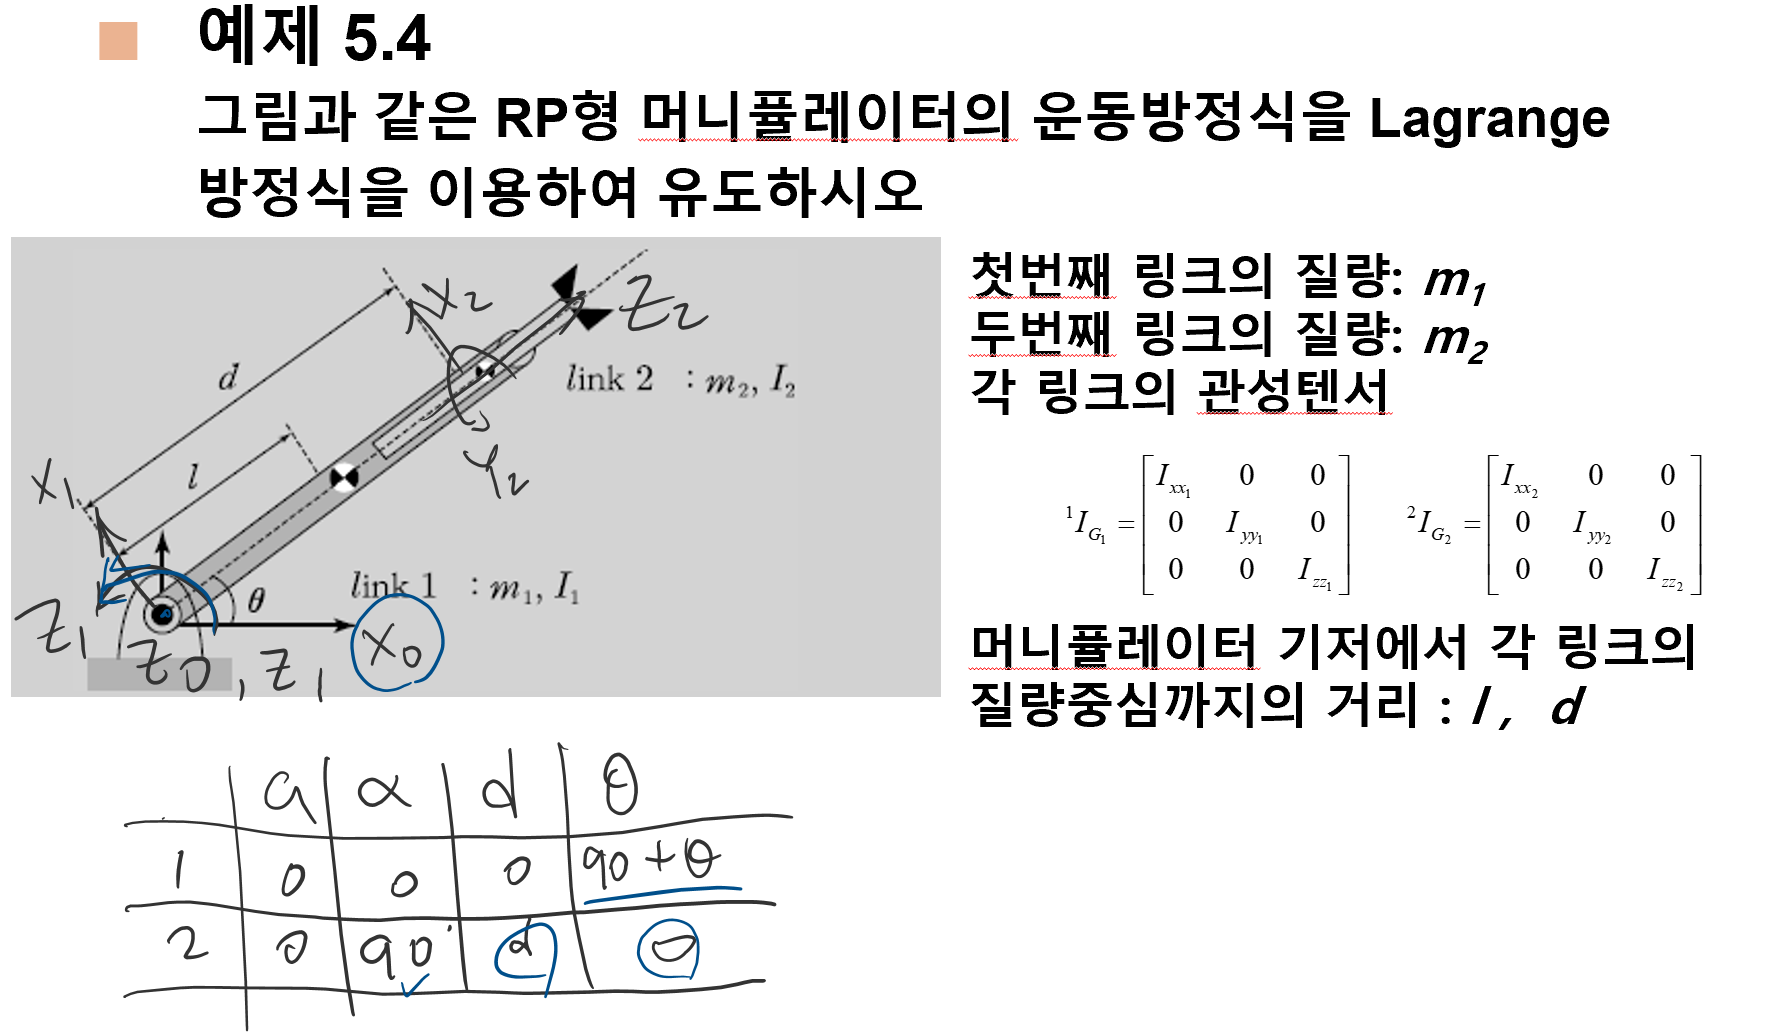

In [7]:
from IPython.display import Image
Image('예제5.4.PNG', width=600)

In [8]:
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector import time_derivative
from sympy.physics.vector import ReferenceFrame
N = ReferenceFrame('N')
th = dynamicsymbols('th')
d = dynamicsymbols('d')

In [9]:
l,IG1,IG2,m1,m2 = sympy.symbols('l,IG1,IG2,m1,m2')

In [10]:
# DH Parameter

In [11]:
T01 = DH(0,0,0,th + sympy.rad(90))

In [12]:
T12 = DH(0,sympy.rad(90),d,0)

In [13]:
T01, T12

⎛⎡-sin(th(t))  -cos(th(t))  0  0⎤  ⎡1  0  0     0  ⎤⎞
⎜⎢                              ⎥  ⎢               ⎥⎟
⎜⎢cos(th(t))   -sin(th(t))  0  0⎥  ⎢0  0  -1  -d(t)⎥⎟
⎜⎢                              ⎥, ⎢               ⎥⎟
⎜⎢     0            0       1  0⎥  ⎢0  1  0     0  ⎥⎟
⎜⎢                              ⎥  ⎢               ⎥⎟
⎝⎣     0            0       0  1⎦  ⎣0  0  0     1  ⎦⎠

In [14]:
T02 = sympy.simplify(T01*T12)

In [15]:
T02

⎡-sin(th(t))  0  cos(th(t))  d(t)⋅cos(th(t))⎤
⎢                                           ⎥
⎢cos(th(t))   0  sin(th(t))  d(t)⋅sin(th(t))⎥
⎢                                           ⎥
⎢     0       1      0              0       ⎥
⎢                                           ⎥
⎣     0       0      0              1       ⎦

In [16]:
# 운동에너지 구하기

In [17]:
w_0_0 = sympy.Matrix([[0],[0],[0]])
w_1_1 = get_angular_vel_R(T01,w_0_0,th.diff())
w_2_2 = get_angular_vel_P(T12,w_1_1)

In [18]:
w_1_1,w_2_2

⎛⎡    0    ⎤  ⎡    0    ⎤⎞
⎜⎢         ⎥  ⎢         ⎥⎟
⎜⎢    0    ⎥  ⎢d        ⎥⎟
⎜⎢         ⎥, ⎢──(th(t))⎥⎟
⎜⎢d        ⎥  ⎢dt       ⎥⎟
⎜⎢──(th(t))⎥  ⎢         ⎥⎟
⎝⎣dt       ⎦  ⎣    0    ⎦⎠

In [19]:
v_0_0 = sympy.Matrix([[0],[0],[0]])
v_1_1 = get_linear_vel_R(T01,w_0_0,v_0_0)
v_2_2 = get_linear_vel_P(T12,w_1_1,v_1_1,d.diff())

In [20]:
v_1_1,v_2_2

⎛     ⎡     d        ⎤⎞
⎜     ⎢d(t)⋅──(th(t))⎥⎟
⎜⎡0⎤  ⎢     dt       ⎥⎟
⎜⎢ ⎥  ⎢              ⎥⎟
⎜⎢0⎥, ⎢      0       ⎥⎟
⎜⎢ ⎥  ⎢              ⎥⎟
⎜⎣0⎦  ⎢   d          ⎥⎟
⎜     ⎢   ──(d(t))   ⎥⎟
⎝     ⎣   dt         ⎦⎠

In [21]:
r_1_G1 = sympy.Matrix([[0],[-l],[0]]) #1좌표계 기준으로 링크 1무게중심
r_2_G2 = sympy.Matrix([[0],[0],[0]]) #2좌표계 기준으로 링크 2무게중심 -> 근데 원점에 무게중심에 위치해서 0으로 둠
v_1_G1 = get_com_vel(v_1_1,w_1_1,r_1_G1) #질량중심 속도
v_2_G2 = get_com_vel(v_2_2,w_2_2,r_2_G2) #질량중심 속도

In [22]:
v_1_G1, v_2_G2 #이런 Form이 나와야함

⎛               ⎡     d        ⎤⎞
⎜⎡  d        ⎤  ⎢d(t)⋅──(th(t))⎥⎟
⎜⎢l⋅──(th(t))⎥  ⎢     dt       ⎥⎟
⎜⎢  dt       ⎥  ⎢              ⎥⎟
⎜⎢           ⎥, ⎢      0       ⎥⎟
⎜⎢     0     ⎥  ⎢              ⎥⎟
⎜⎢           ⎥  ⎢   d          ⎥⎟
⎜⎣     0     ⎦  ⎢   ──(d(t))   ⎥⎟
⎝               ⎣   dt         ⎦⎠

In [23]:
# 운동에너지
Ixx1,Iyy1,Izz1,Ixx2,Iyy2,Izz2 = sympy.symbols('Ixx1,Iyy1,Izz1,Ixx2,Iyy2,Izz2')
I_1_G1 = sympy.Matrix([[Ixx1,0,0],[0,Iyy1,0],[0,0,Izz1]]) #문제에 정의가 되어있음
I_2_G2 = sympy.Matrix([[Ixx2,0,0],[0,Iyy2,0],[0,0,Izz2]]) #문제에 정의가 되어있음
T = get_kinectic_energy(m1,v_1_G1,I_1_G1,w_1_1) + get_kinectic_energy(m2,v_2_G2,I_2_G2,w_2_2)

In [24]:
T

⎡                    2                       2                        2       
⎢         ⎛d        ⎞             ⎛d        ⎞         2    ⎛d        ⎞        
⎢0.5⋅Iyy₂⋅⎜──(th(t))⎟  + 0.5⋅Izz₁⋅⎜──(th(t))⎟  + 0.5⋅l ⋅m₁⋅⎜──(th(t))⎟  + 0.5⋅
⎣         ⎝dt       ⎠             ⎝dt       ⎠              ⎝dt       ⎠        

                    2                    2⎤
    2    ⎛d        ⎞           ⎛d       ⎞ ⎥
m₂⋅d (t)⋅⎜──(th(t))⎟  + 0.5⋅m₂⋅⎜──(d(t))⎟ ⎥
         ⎝dt       ⎠           ⎝dt      ⎠ ⎦

In [25]:
# 위치에너지 구하기

In [26]:
g = sympy.symbols('g')

In [27]:
g_0 = sympy.Matrix([[0],[-g],[0]]) #0좌표계에서의 g

In [28]:
V = get_potential_energy(T01,m1,g_0,r_1_G1) + get_potential_energy(T02,m2,g_0,r_2_G2)

In [29]:
V

[g⋅l⋅m₁⋅sin(th(t)) + g⋅m₂⋅d(t)⋅sin(th(t))]

In [30]:
# 라그랑지안 구하기
L = get_lagrangian(T,V)

In [31]:
L

⎡                    2                       2                                
⎢         ⎛d        ⎞             ⎛d        ⎞                                 
⎢0.5⋅Iyy₂⋅⎜──(th(t))⎟  + 0.5⋅Izz₁⋅⎜──(th(t))⎟  - g⋅l⋅m₁⋅sin(th(t)) - g⋅m₂⋅d(t)
⎣         ⎝dt       ⎠             ⎝dt       ⎠                                 

                                   2                           2              
                   2    ⎛d        ⎞            2    ⎛d        ⎞           ⎛d  
⋅sin(th(t)) + 0.5⋅l ⋅m₁⋅⎜──(th(t))⎟  + 0.5⋅m₂⋅d (t)⋅⎜──(th(t))⎟  + 0.5⋅m₂⋅⎜──(
                        ⎝dt       ⎠                 ⎝dt       ⎠           ⎝dt 

      2⎤
     ⎞ ⎥
d(t))⎟ ⎥
     ⎠ ⎦

In [32]:
q = sympy.Matrix([[th],[d]])
qd = sympy.Matrix([[th.diff()],[d.diff()]])
tau = get_torque_from_L(L,q,qd)

In [33]:
# Get Equation of Motion

In [34]:
tau

⎡           2                     2                                           
⎢          d                     d                                            
⎢1.0⋅Iyy₂⋅───(th(t)) + 1.0⋅Izz₁⋅───(th(t)) + g⋅(l⋅m₁ + m₂⋅d(t))⋅cos(th(t)) + 1
⎢           2                     2                                           
⎢         dt                    dt                                            
⎢                                                                             
⎢                                                   ⎛                         
⎢                                                   ⎜                         
⎢                                              - m₂⋅⎜-g⋅sin(th(t)) + 1.0⋅d(t)⋅
⎢                                                   ⎝                         
⎣                                                                             

           2                         2                                        
    2     d                   2     d              

In [35]:
qdd = sympy.Matrix([[th.diff().diff()],[d.diff().diff()]])
M_, C_, G_ = get_EoM_from_T(tau,qdd,g)

In [36]:
M_

⎡                           2              2           ⎤
⎢1.0⋅Iyy₂ + 1.0⋅Izz₁ + 1.0⋅l ⋅m₁ + 1.0⋅m₂⋅d (t)    0   ⎥
⎢                                                      ⎥
⎣                      0                         1.0⋅m₂⎦

In [37]:
C_

⎡            d        d        ⎤
⎢2.0⋅m₂⋅d(t)⋅──(d(t))⋅──(th(t))⎥
⎢            dt       dt       ⎥
⎢                              ⎥
⎢                          2   ⎥
⎢               ⎛d        ⎞    ⎥
⎢  -1.0⋅m₂⋅d(t)⋅⎜──(th(t))⎟    ⎥
⎣               ⎝dt       ⎠    ⎦

In [38]:
sympy.simplify(G_)

⎡g⋅(l⋅m₁ + m₂⋅d(t))⋅cos(th(t))⎤
⎢                             ⎥
⎣       g⋅m₂⋅sin(th(t))       ⎦